In [1]:
import os
import torch
import numpy as np
import random
import pandas as pd
from pathlib import Path

# Fix random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset and output paths
RAW_DIR = "/kaggle/input/ur-fall-detection-dataset"
OUT_DIR = "/kaggle/working/urfd_preprocessed"
os.makedirs(OUT_DIR, exist_ok=True)

print("Raw dataset path:", RAW_DIR)
print("Preprocessed data will be saved in:", OUT_DIR)


Raw dataset path: /kaggle/input/ur-fall-detection-dataset
Preprocessed data will be saved in: /kaggle/working/urfd_preprocessed


In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- Paths ---
ROOT_DIR = "/kaggle/input/ur-fall-detection-dataset/UR_fall_detection_dataset_cam0_rgb"

# --- Parameters ---
IMG_SIZE = (112, 112)
NUM_FRAMES = 16  # sample 16 frames per clip

# --- Collect video sequences ---
def load_video_frames(folder_path, num_frames=NUM_FRAMES):
    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".png")])
    total_frames = len(frame_files)
    if total_frames < num_frames:
        # repeat frames if too few
        frame_files = (frame_files * (num_frames // total_frames + 1))[:num_frames]
    else:
        # sample evenly across sequence
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
        frame_files = [frame_files[i] for i in indices]

    frames = []
    for file in frame_files:
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # normalize
        frames.append(img)

    return np.array(frames)  # shape: (frames, height, width, channels)

# --- Prepare dataset ---
X, y = [], []
for subfolder in tqdm(os.listdir(ROOT_DIR), desc="Loading sequences"):
    folder_path = os.path.join(ROOT_DIR, subfolder)
    if not os.path.isdir(folder_path):
        continue
    label = 1 if "fall" in subfolder.lower() else 0  # 1 = fall, 0 = ADL
    try:
        video_tensor = load_video_frames(folder_path)
        X.append(video_tensor)
        y.append(label)
    except Exception as e:
        print(f"Skipping {folder_path} due to error: {e}")

X = np.array(X)
y = np.array(y)
print(f"✅ Loaded {len(X)} sequences")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# --- Split into train/val/test ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Loading sequences: 100%|██████████| 70/70 [00:21<00:00,  3.28it/s]


✅ Loaded 70 sequences
Shape of X: (70, 16, 112, 112, 3), Shape of y: (70,)
Train: 49, Val: 10, Test: 11


In [6]:
# CELL 0 - Settings & imports
import os, random, math, shutil, gc
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc as compute_auc
)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Paths (edit if you used a different OUT_DIR)
ROOT_FRAMES = "/kaggle/input/ur-fall-detection-dataset/UR_fall_detection_dataset_cam0_rgb"
WORK_DIR = "/kaggle/working/urfd_work"   # will create outputs here
os.makedirs(WORK_DIR, exist_ok=True)

# Hyperparams
NUM_FRAMES = 16            # frames per clip
IMG_SIZE = 112             # height & width
BATCH_SIZE = 4             # small for Kaggle GPU memory
LR = 1e-4
EPOCHS = 12                # increase if you have more runtime
NUM_WORKERS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)
print("Root frames:", ROOT_FRAMES)
print("Work dir:", WORK_DIR)


Device: cpu
Root frames: /kaggle/input/ur-fall-detection-dataset/UR_fall_detection_dataset_cam0_rgb
Work dir: /kaggle/working/urfd_work


In [7]:
# CELL 1 - Build metadata (video folder list & labels)
records = []
for sub in sorted(os.listdir(ROOT_FRAMES)):
    folder = os.path.join(ROOT_FRAMES, sub)
    if not os.path.isdir(folder): 
        continue
    label = 1 if "fall" in sub.lower() else 0  # 1=fall, 0=adl
    records.append({"video_id": sub, "path": folder, "label": label})

meta = pd.DataFrame(records)
print("Total sequences found:", len(meta))
print(meta.label.value_counts())
meta.to_csv(os.path.join(WORK_DIR, "metadata_all.csv"), index=False)
meta.head()


Total sequences found: 70
label
0    40
1    30
Name: count, dtype: int64


,video_id,path,label
0,adl-01-cam0-rgb,/kaggle/input/ur-fall-detection-dataset/UR_fal...,0
1,adl-02-cam0-rgb,/kaggle/input/ur-fall-detection-dataset/UR_fal...,0
2,adl-03-cam0-rgb,/kaggle/input/ur-fall-detection-dataset/UR_fal...,0
3,adl-04-cam0-rgb,/kaggle/input/ur-fall-detection-dataset/UR_fal...,0
4,adl-05-cam0-rgb,/kaggle/input/ur-fall-detection-dataset/UR_fal...,0


In [8]:
# CELL 2 - Split dataset (stratified)
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(meta, test_size=0.30, stratify=meta['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

for df, name in zip([train_df, val_df, test_df], ["train", "val", "test"]):
    df.to_csv(os.path.join(WORK_DIR, f"{name}_meta.csv"), index=False)
    print(name, len(df), df.label.value_counts().to_dict())


train 49 {0: 28, 1: 21}
val 10 {0: 6, 1: 4}
test 11 {0: 6, 1: 5}


In [10]:
# CELL 3 - Dataset & transforms
from PIL import Image
import torchvision.transforms.functional as F

def load_frame_rgb(path):
    # return PIL RGB
    return Image.open(path).convert("RGB")

def sample_frame_list(frame_folder, num_frames=NUM_FRAMES, mode='train'):
    files = sorted([f for f in os.listdir(frame_folder) if f.endswith((".png", ".jpg", ".jpeg"))])
    n = len(files)
    if n == 0:
        raise RuntimeError(f"No frames in folder {frame_folder}")
    if n < num_frames:
        # repeat to reach required frames
        files = (files * (num_frames // n + 1))[:num_frames]
        idxs = list(range(num_frames))
    else:
        if mode == 'train':
            start = random.randint(0, n - num_frames)
        else:
            start = max(0, (n - num_frames)//2)
        idxs = list(range(start, start + num_frames))
    return [os.path.join(frame_folder, files[i]) for i in idxs]

def video_augmentations(imgs, train=True, crop_size=IMG_SIZE):
    # imgs: list of PIL images (all same size)
    w, h = imgs[0].size
    # spatial params (consistent across frames)
    do_flip = train and (random.random() < 0.5)
    angle = random.uniform(-8, 8) if train else 0.0
    if train:
        top = random.randint(0, max(0, h - crop_size))
        left = random.randint(0, max(0, w - crop_size))
    else:
        top = max(0, (h - crop_size)//2)
        left = max(0, (w - crop_size)//2)
    out = []
    for im in imgs:
        if do_flip:
            im = F.hflip(im)
        if angle != 0:
            im = F.rotate(im, angle)
        im = F.crop(im, top, left, crop_size, crop_size)
        t = F.to_tensor(im)          # tensor in [0,1], shape (C,H,W)
        out.append(t)
    return out  # list of tensors CxHxW

class VideoClipDataset(Dataset):
    def __init__(self, meta_csv, num_frames=NUM_FRAMES, train=True):
        self.df = pd.read_csv(meta_csv)
        self.num_frames = num_frames
        self.train = train
        self.label_map = {0:0, 1:1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        folder = row['path']
        frame_paths = sample_frame_list(folder, self.num_frames, mode='train' if self.train else 'eval')
        imgs = [load_frame_rgb(p) for p in frame_paths]
        imgs = video_augmentations(imgs, train=self.train)
        # stack to tensor of shape (C, T, H, W)
        clip = torch.stack(imgs, dim=1)   # each img CxHxW -> stack -> C x T x H x W
        label = int(row['label'])
        return clip.float(), torch.tensor(label, dtype=torch.long)


In [11]:
# CELL 4 - Dataloaders and sampler
train_ds = VideoClipDataset(os.path.join(WORK_DIR, "train_meta.csv"), train=True)
val_ds = VideoClipDataset(os.path.join(WORK_DIR, "val_meta.csv"), train=False)
test_ds = VideoClipDataset(os.path.join(WORK_DIR, "test_meta.csv"), train=False)

# Weighted sampler
train_meta = pd.read_csv(os.path.join(WORK_DIR, "train_meta.csv"))
class_counts = train_meta.label.value_counts().to_dict()
print("Train class counts:", class_counts)
class_sample_count = np.array([class_counts.get(0,0), class_counts.get(1,0)])
class_weight = 1. / (class_sample_count + 1e-8)
samples_weight = [class_weight[int(l)] for l in train_meta.label.values]
samples_weight = torch.DoubleTensor(samples_weight)
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Loaders ready. Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train class counts: {0: 28, 1: 21}
Loaders ready. Train batches: 13 Val batches: 3


In [12]:
# CELL 5 - Model definition (Simple 3D CNN)
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3,3,3), padding=1), nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),   # pool spatially first
            nn.Conv3d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            nn.Conv3d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d((1,1,1)),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (B, C, T, H, W)
        x = self.features(x)
        x = self.classifier(x)
        return x

model = Simple3DCNN(num_classes=2).to(DEVICE)
print(model)


Simple3DCNN(
  (features): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool3d(output_size=(1, 1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128

In [13]:
# CELL 6 - Train & eval functions
criterion = nn.CrossEntropyLoss()  # class weights handled via sampler
optimizer = optim.Adam(model.parameters(), lr=LR)

def evaluate_model(loader, model):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for clips, labels in loader:
            clips = clips.to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(clips)
            prob = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            pred = logits.argmax(dim=1).cpu().numpy()
            ys.extend(labels.cpu().numpy())
            preds.extend(pred)
            probs.extend(prob)
    ys = np.array(ys); preds = np.array(preds); probs = np.array(probs)
    return ys, preds, probs

def compute_metrics(ys, preds, probs):
    acc = accuracy_score(ys, preds)
    p, r, f1, _ = precision_recall_fscore_support(ys, preds, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(ys, probs)
    except:
        auc = float('nan')
    return {"accuracy":acc, "precision":p, "recall":r, "f1":f1, "auc":auc}

# Training loop
best_val_f1 = -1.0
history = []
for epoch in range(1, EPOCHS+1):
    model.train()
    losses = []
    for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch} - train"):
        clips = clips.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(clips)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    # validate
    ys_val, preds_val, probs_val = evaluate_model(val_loader, model)
    metrics = compute_metrics(ys_val, preds_val, probs_val)
    metrics['train_loss'] = np.mean(losses)
    history.append(metrics)
    print(f"Epoch {epoch} | Loss {metrics['train_loss']:.4f} | Val F1 {metrics['f1']:.4f} | Val AUC {metrics['auc']:.4f}")
    # save best
    if metrics['f1'] > best_val_f1:
        best_val_f1 = metrics['f1']
        torch.save(model.state_dict(), os.path.join(WORK_DIR, "best_model.pt"))
        print("  -> Saved best model (val f1 improved).")

# Save training history
pd.DataFrame(history).to_csv(os.path.join(WORK_DIR, "train_history.csv"), index=False)


Epoch 1 - train: 100%|██████████| 13/13 [01:05<00:00,  5.06s/it]


Epoch 1 | Loss 0.6808 | Val F1 0.5714 | Val AUC 0.7083
  -> Saved best model (val f1 improved).


Epoch 2 - train: 100%|██████████| 13/13 [01:23<00:00,  6.41s/it]


Epoch 2 | Loss 0.6911 | Val F1 0.5714 | Val AUC 0.7083


Epoch 3 - train: 100%|██████████| 13/13 [01:07<00:00,  5.19s/it]


Epoch 3 | Loss 0.6860 | Val F1 0.6154 | Val AUC 0.7083
  -> Saved best model (val f1 improved).


Epoch 4 - train: 100%|██████████| 13/13 [01:07<00:00,  5.18s/it]


Epoch 4 | Loss 0.6632 | Val F1 0.6667 | Val AUC 0.6667
  -> Saved best model (val f1 improved).


Epoch 5 - train: 100%|██████████| 13/13 [01:06<00:00,  5.12s/it]


Epoch 5 | Loss 0.6684 | Val F1 0.6667 | Val AUC 0.7083


Epoch 6 - train: 100%|██████████| 13/13 [01:07<00:00,  5.17s/it]


Epoch 6 | Loss 0.6866 | Val F1 0.0000 | Val AUC 0.7083


Epoch 7 - train: 100%|██████████| 13/13 [01:07<00:00,  5.16s/it]


Epoch 7 | Loss 0.7053 | Val F1 0.0000 | Val AUC 0.7083


Epoch 8 - train: 100%|██████████| 13/13 [01:06<00:00,  5.10s/it]


Epoch 8 | Loss 0.6841 | Val F1 0.6667 | Val AUC 0.7083


Epoch 9 - train: 100%|██████████| 13/13 [01:07<00:00,  5.18s/it]


Epoch 9 | Loss 0.6280 | Val F1 0.6667 | Val AUC 0.7083


Epoch 10 - train: 100%|██████████| 13/13 [01:21<00:00,  6.27s/it]


Epoch 10 | Loss 0.6960 | Val F1 0.7273 | Val AUC 0.7083
  -> Saved best model (val f1 improved).


Epoch 11 - train: 100%|██████████| 13/13 [01:06<00:00,  5.14s/it]


Epoch 11 | Loss 0.6620 | Val F1 0.6667 | Val AUC 0.7083


Epoch 12 - train: 100%|██████████| 13/13 [01:06<00:00,  5.10s/it]


Epoch 12 | Loss 0.6020 | Val F1 0.7273 | Val AUC 0.7083


Loaded best model: /kaggle/working/urfd_work/best_model.pt
Test metrics: {'accuracy': 0.6363636363636364, 'precision': 0.5555555555555556, 'recall': 1.0, 'f1': 0.7142857142857143, 'auc': 0.7666666666666667}

Classification Report:
               precision    recall  f1-score   support

         adl       1.00      0.33      0.50         6
        fall       0.56      1.00      0.71         5

    accuracy                           0.64        11
   macro avg       0.78      0.67      0.61        11
weighted avg       0.80      0.64      0.60        11

Confusion matrix:
 [[2 4]
 [0 5]]


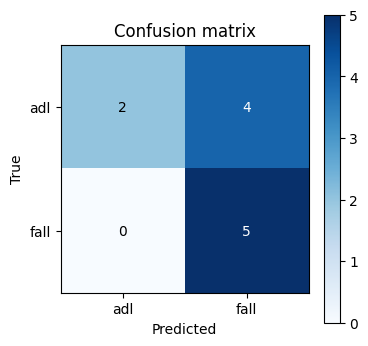

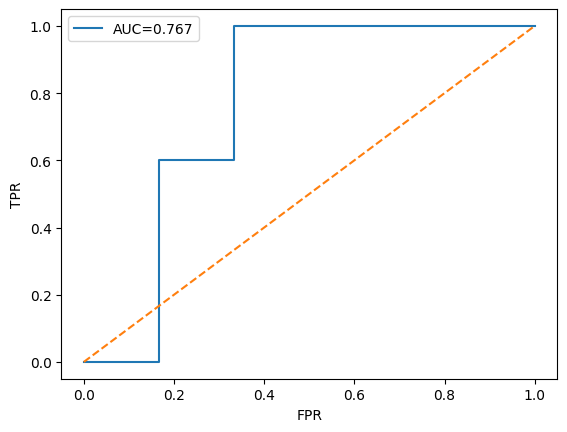

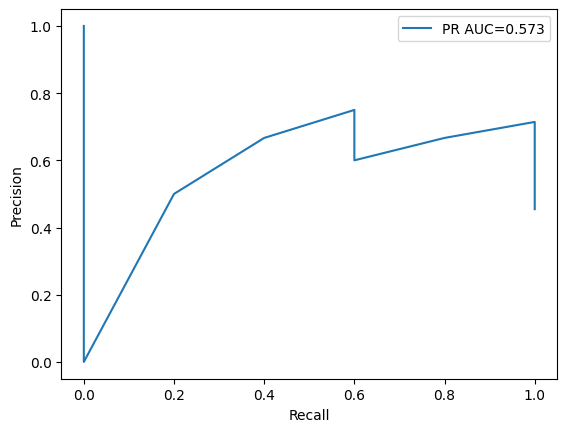

In [14]:
# CELL 7 - Load best model and evaluate on test set
best_state = os.path.join(WORK_DIR, "best_model.pt")
if os.path.exists(best_state):
    model.load_state_dict(torch.load(best_state, map_location=DEVICE))
    print("Loaded best model:", best_state)

ys_test, preds_test, probs_test = evaluate_model(test_loader, model)
metrics_test = compute_metrics(ys_test, preds_test, probs_test)
print("Test metrics:", metrics_test)
print("\nClassification Report:\n", classification_report(ys_test, preds_test, target_names=["adl","fall"], zero_division=0))

# Confusion Matrix
cm = confusion_matrix(ys_test, preds_test)
print("Confusion matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xticks([0,1], ["adl","fall"])
plt.yticks([0,1], ["adl","fall"])
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j],ha="center",va="center",color="white" if cm[i,j]>max(cm.flatten())/2 else "black")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(ys_test, probs_test)
roc_auc = compute_auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(ys_test, probs_test)
pr_auc = compute_auc(recall, precision)
plt.figure(); plt.plot(recall, precision, label=f"PR AUC={pr_auc:.3f}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.show()


In [15]:
# CELL 8 - Save FP and FN examples for visual inspection
OUT_ERR = os.path.join(WORK_DIR, "error_examples")
shutil.rmtree(OUT_ERR, ignore_errors=True)
os.makedirs(OUT_ERR, exist_ok=True)

# Map dataset index to meta
test_meta = pd.read_csv(os.path.join(WORK_DIR, "test_meta.csv")).reset_index(drop=True)

# Build predictions per-sample with file path
all_preds = []
model.eval()
with torch.no_grad():
    for i, (clip, label) in enumerate(test_loader):
        # dataloader yields batches of clips; need to map to linear indices
        # We'll re-run to get per-sample index mapping simpler:
        pass

# Simpler: iterate test_meta directly and run model single-sample to know which are FP/FN
fp_dirs, fn_dirs = [], []
for idx, row in test_meta.iterrows():
    # Create a small dataset single-sample
    from PIL import Image
    frame_paths = sample_frame_list(row['path'], NUM_FRAMES, mode='eval')
    imgs = [load_frame_rgb(p) for p in frame_paths]
    imgs = video_augmentations(imgs, train=False)
    clip = torch.stack(imgs, dim=1).unsqueeze(0).to(DEVICE)  # 1xCxTxHxW
    with torch.no_grad():
        logits = model(clip)
        prob = torch.softmax(logits, dim=1)[:,1].cpu().item()
        pred = logits.argmax(dim=1).cpu().item()
    true = int(row['label'])
    if pred == 1 and true == 0:
        # false positive
        dst = os.path.join(OUT_ERR, f"FP_{row['video_id']}")
        os.makedirs(dst, exist_ok=True)
        # save representative frames (first, middle, last)
        for j,p in enumerate([frame_paths[0], frame_paths[len(frame_paths)//2], frame_paths[-1]]):
            shutil.copy(p, os.path.join(dst, f"{j:02d}_{Path(p).name}"))
        fp_dirs.append((row['video_id'], prob))
    if pred == 0 and true == 1:
        dst = os.path.join(OUT_ERR, f"FN_{row['video_id']}")
        os.makedirs(dst, exist_ok=True)
        for j,p in enumerate([frame_paths[0], frame_paths[len(frame_paths)//2], frame_paths[-1]]):
            shutil.copy(p, os.path.join(dst, f"{j:02d}_{Path(p).name}"))
        fn_dirs.append((row['video_id'], prob))

print("FP count:", len(fp_dirs), "FN count:", len(fn_dirs))
print("Saved examples in:", OUT_ERR)


FP count: 4 FN count: 0
Saved examples in: /kaggle/working/urfd_work/error_examples
